In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

from train import *
from utils import get_sobol_indices

Load data and configuration

In [2]:
cohort = "hmp"

config = importlib.import_module("config")
attrs = importlib.import_module(f"{cohort}_data")
args = getattr(config, "args")

args.name = f"{args.cohort}-{args.task}-{args.method}"
args.name += f"-L{args.latent_dim}-test"

Train model

In [ ]:
results = train1(attrs, args)
model = results["model"]
torch.save(model, f"{args.name}.pt")

In [4]:
model = torch.load(Path(f"{args.name}.pt"), weights_only=False)

In [5]:
model.eval()
B = model.get_beta()
L = model.latent_dim
dataset = MetagenomeDataset(attrs.y, attrs.x_num, attrs.x_cat)
X = dataset[:]["x"]
Y = dataset[:]["y"]
X_mask = dataset[:]["x_mask"]
theta = model.get_theta(X, Y, X_mask)

In [6]:
def get_theta(x):
    x = np.transpose(x)
    x = torch.Tensor(x)
    theta = model.get_theta(x)
    f_eval = np.transpose(theta)
    return f_eval

sobol_result, sobol_agg = get_sobol_indices(get_theta, dataset, attrs)

Visualization

In [7]:

plt.rcParams.update({
    "figure.figsize": [3.5, 2.625],
    "lines.linewidth": 1,
    "font.family": "serif",
    "font.size": 10,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42
})

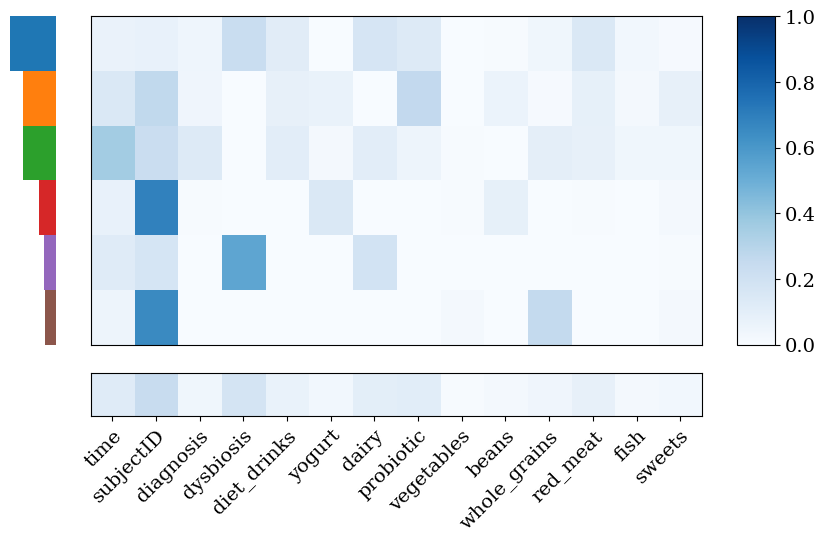

In [8]:
plt.rcParams.update({"font.size": 14})
save_fmt = ""
colors = list(map(mpl.colors.to_hex, mpl.color_sequences["tab10"]))
topic_props = np.mean(theta, axis=0)
l_sorted = np.argsort(np.mean(theta, axis=0))[::-1]
fig = plt.figure(figsize=(9, 5))
gs = fig.add_gridspec(
    2,
    3,
    width_ratios=[0.6, 8, 0.5],
    height_ratios=[6, 0.8],
    hspace=0.15,
    wspace=0.15,
)

ax_stack = fig.add_subplot(gs[0, 0])
ax_sobol = fig.add_subplot(gs[0, 1])
ax_cbar = fig.add_subplot(gs[0, 2])
ax_agg_left = fig.add_subplot(gs[1, 0])
ax_agg_right = fig.add_subplot(gs[1, 1])

topic_props_sorted = topic_props[l_sorted]
topic_colors_sorted = [colors[i % len(colors)] for i in range(len(l_sorted))]

n_topics = len(l_sorted)
for i, (prop, color) in enumerate(zip(topic_props_sorted, topic_colors_sorted)):
    y_bottom = (n_topics - 1 - i) / n_topics
    y_height = 1 / n_topics
    max_prop = max(topic_props_sorted)
    width = prop / max_prop
    x_start = 1 - width
    rect = plt.Rectangle((x_start, y_bottom), width, y_height, facecolor=color)
    ax_stack.add_patch(rect)

ax_stack.set_xlim(0, 1)
ax_stack.set_ylim(0, 1)
ax_stack.set_xticks([])
ax_stack.set_yticks([])
for spine in ax_stack.spines.values():
    spine.set_visible(False)

sobol_ordered = sobol_result.total_order[l_sorted, :]
col_labels = attrs.x_cols
im2 = ax_sobol.imshow(sobol_ordered, cmap="Blues", aspect="auto", vmin=0, vmax=1)
ax_sobol.set_xticks([])
ax_sobol.set_xticklabels([])
ax_sobol.set_yticks([])
ax_sobol.set_yticklabels([])
cbar = plt.colorbar(im2, cax=ax_cbar)

ax_agg_left.axis("off")
sobol_agg_2d = sobol_agg.reshape(1, -1)
im_agg = ax_agg_right.imshow(sobol_agg_2d, cmap="Blues", aspect="auto", vmin=0, vmax=1)
ax_agg_right.set_xticks(range(len(col_labels)))
ax_agg_right.set_xticklabels(
    col_labels, ha="right", rotation=45, rotation_mode="anchor"
)
ax_agg_right.set_yticks([])
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)
if save_fmt:
    plt.savefig(f"{cohort}-si.{save_fmt}")

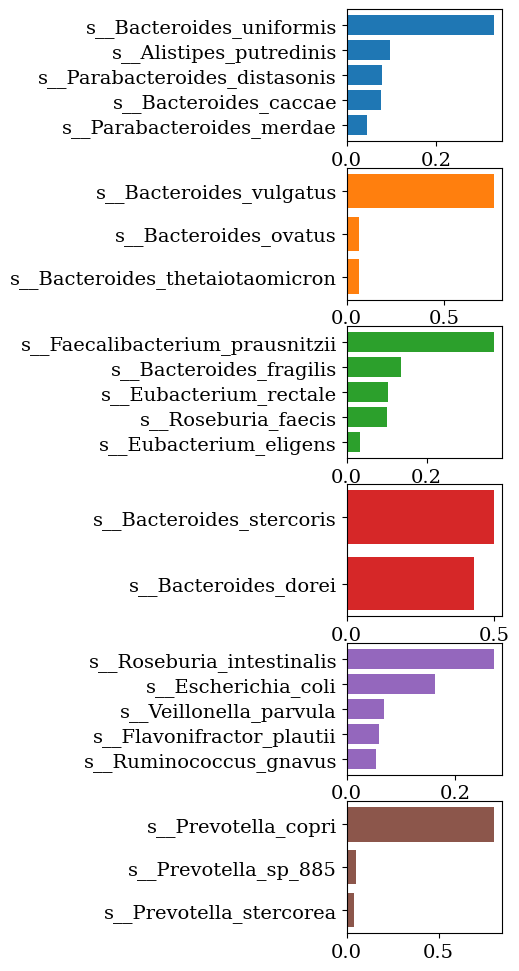

In [9]:
species = attrs.species
top_n = 20
top_species_indices = np.unique(np.argsort(B, axis=1)[:, -top_n:])
top_species = list(species[top_species_indices])
top_values = B[:, top_species_indices]

colors = list(map(mpl.colors.to_hex, mpl.color_sequences["tab10"]))
top_k = 5
num_topics = B.shape[0]
fig, axes = plt.subplots(num_topics, 1, figsize=(2, 12), sharex=False)
fig.subplots_adjust(wspace=0.1)
if num_topics == 1:
    axes = [axes]
l_sorted = np.argsort(np.mean(theta, axis=0))[::-1]
for cnt, l in enumerate(l_sorted):
    topic_weights = B[l]
    threshold = 0.03
    valid_indices = np.where(np.abs(topic_weights) > threshold)[0]
    if len(valid_indices) > 0:
        sorted_valid_indices = valid_indices[
            np.argsort(np.abs(topic_weights[valid_indices]))[::-1]
        ]
        top_indices = sorted_valid_indices[:top_k]
        top_k_species = [species[idx] for idx in top_indices]
        top_k_values = topic_weights[top_indices]
        axes[cnt].barh(top_k_species, top_k_values, color=colors[cnt % len(colors)])
    axes[cnt].invert_yaxis()
    axes[cnt].set_xlabel("")
    axes[cnt].set_ylabel("")
if save_fmt:
    plt.savefig(f"{cohort}-topics.{save_fmt}")

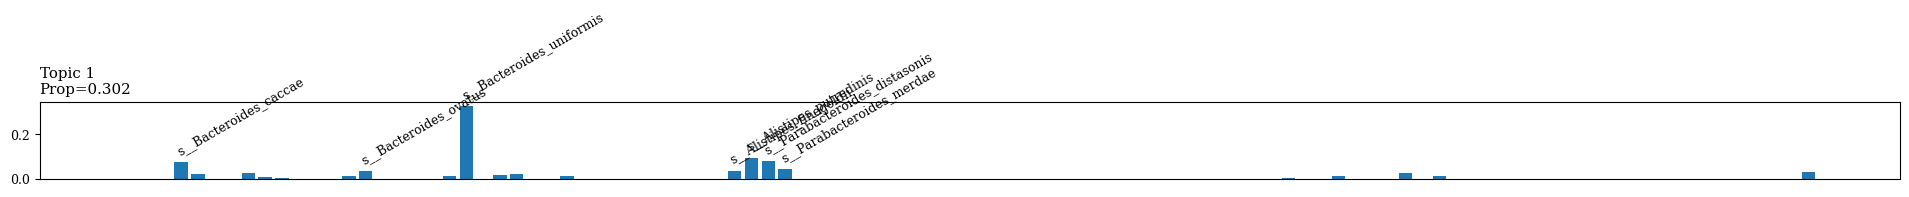

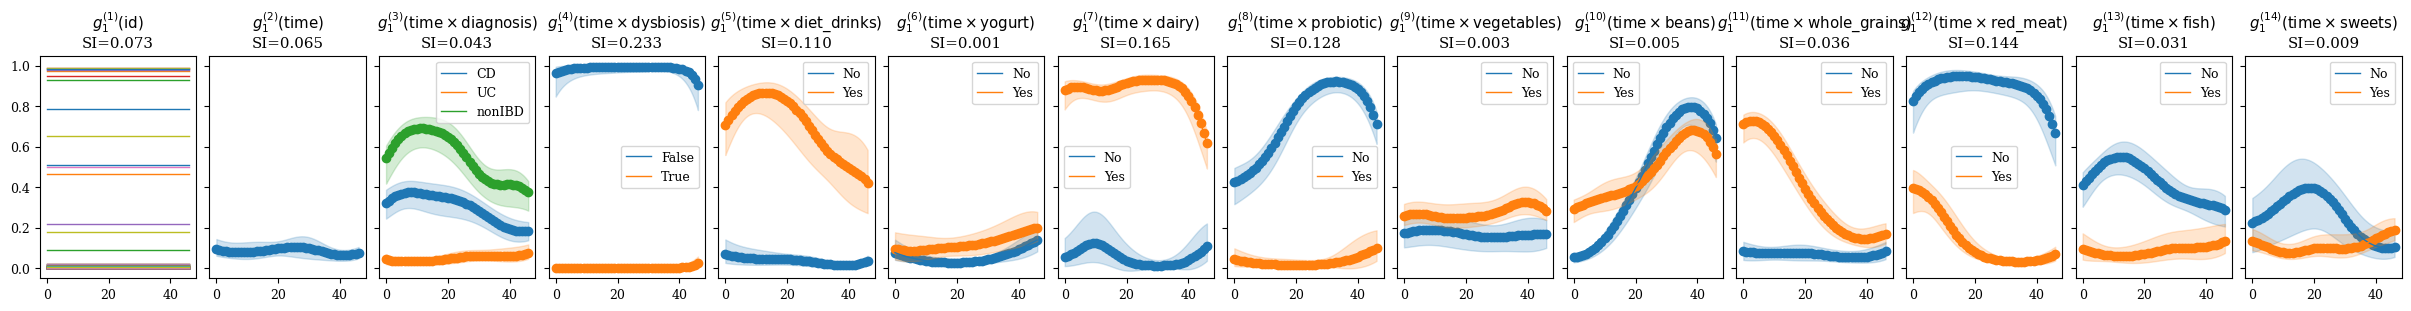

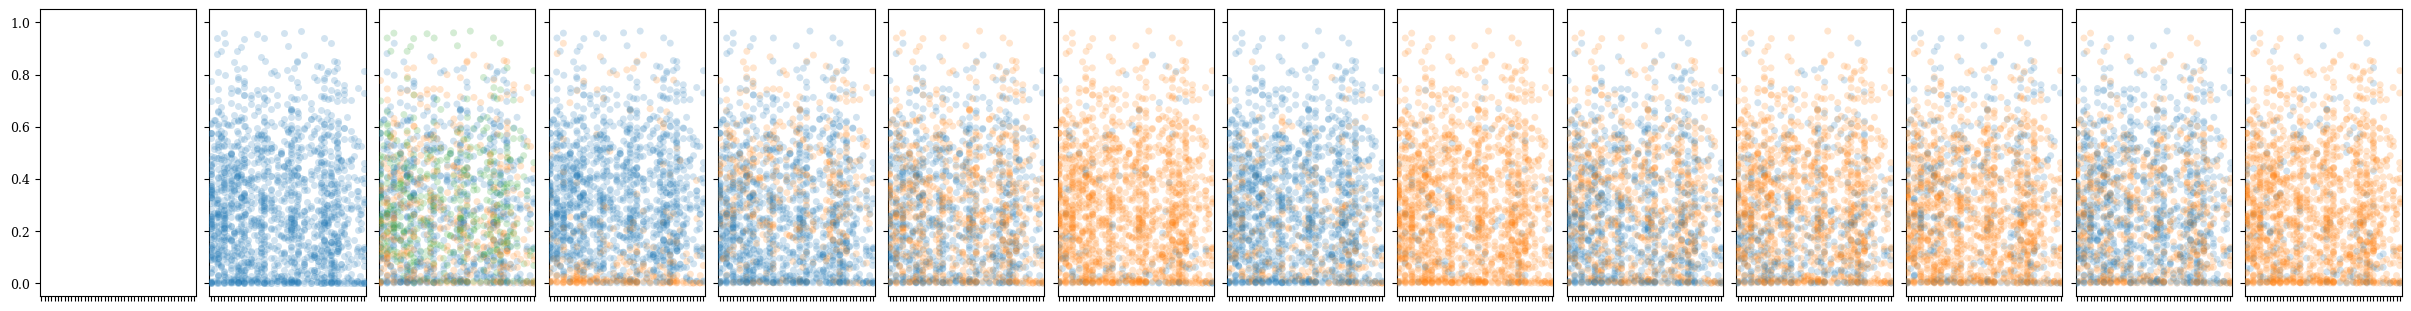

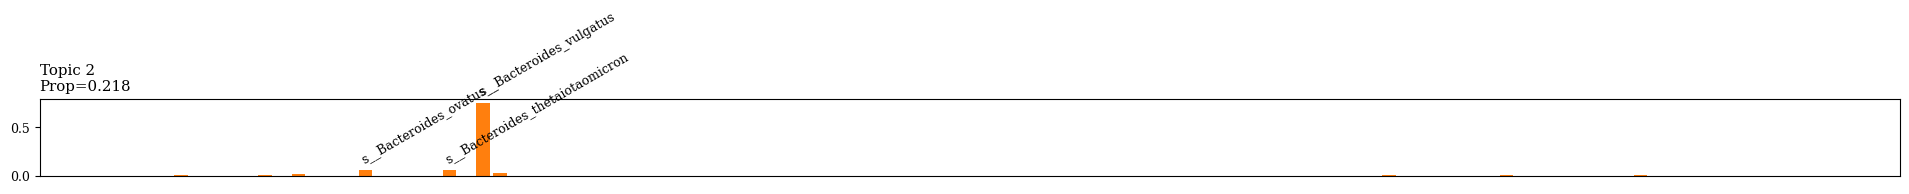

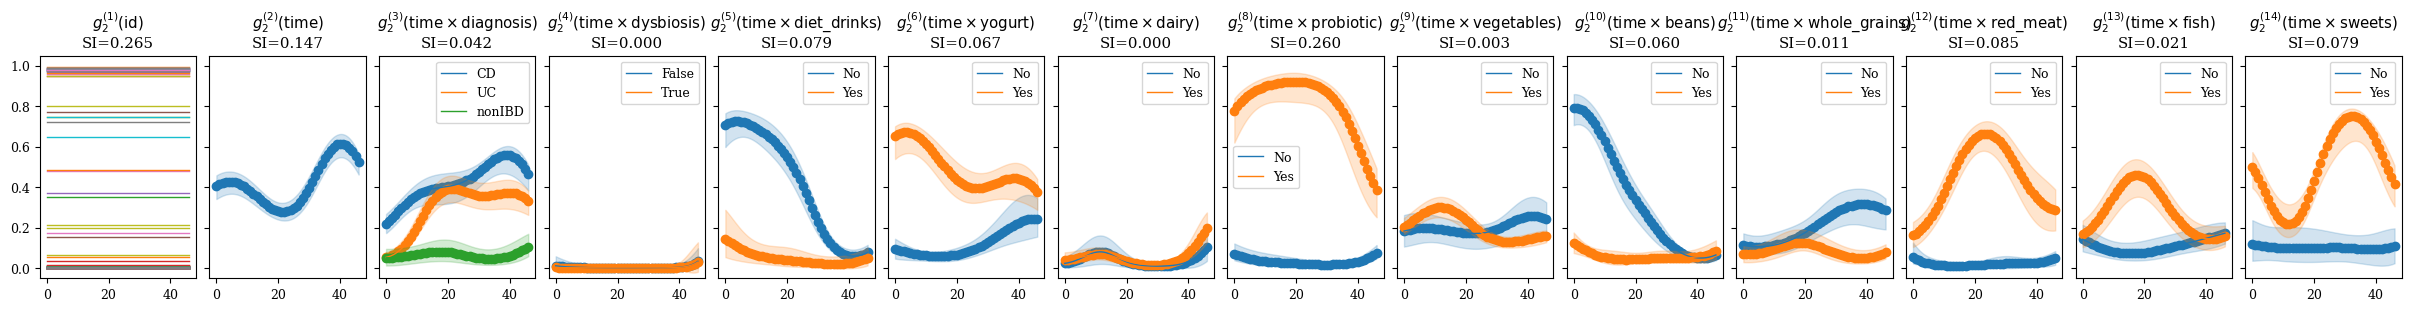

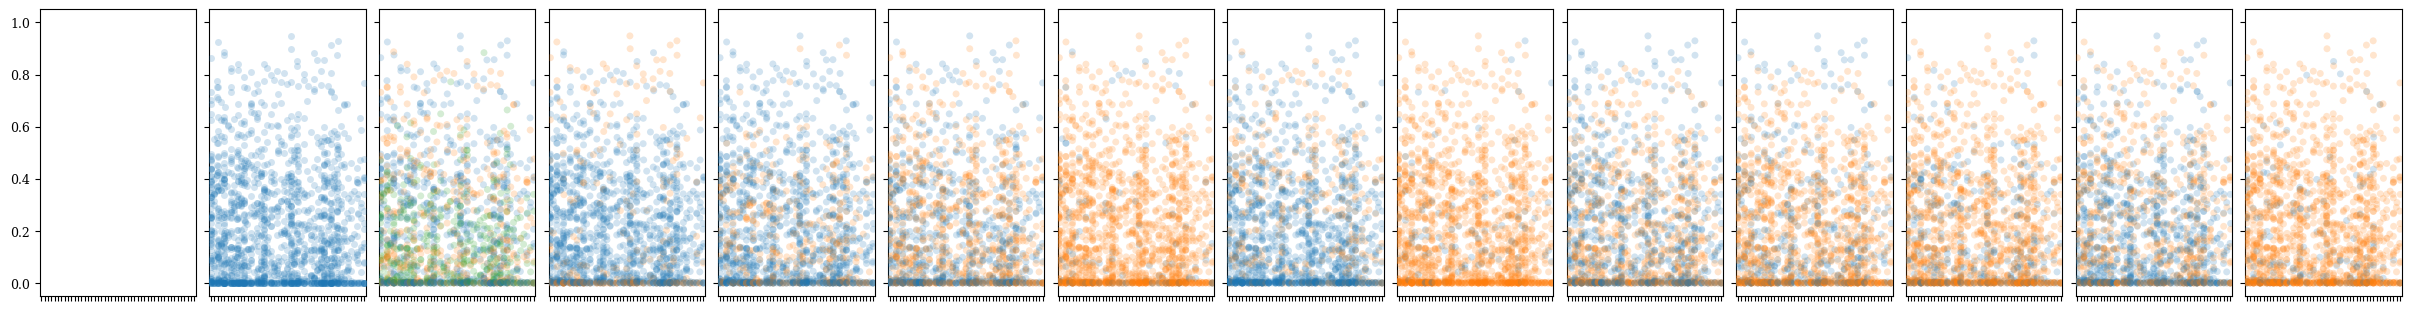

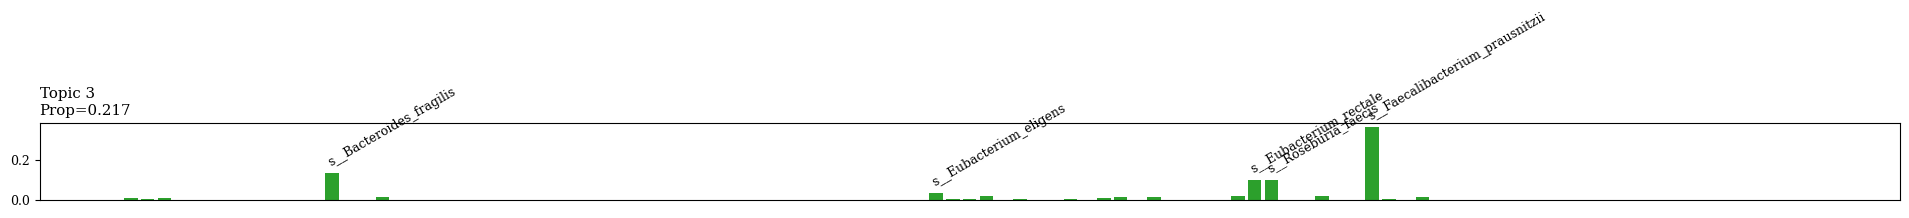

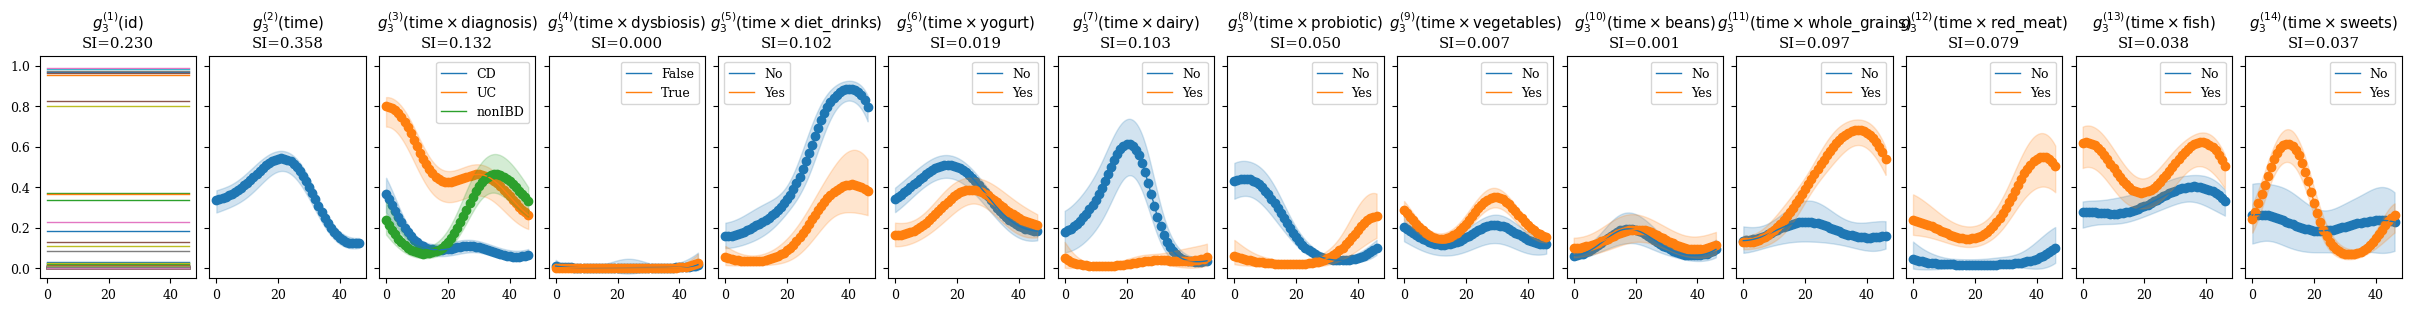

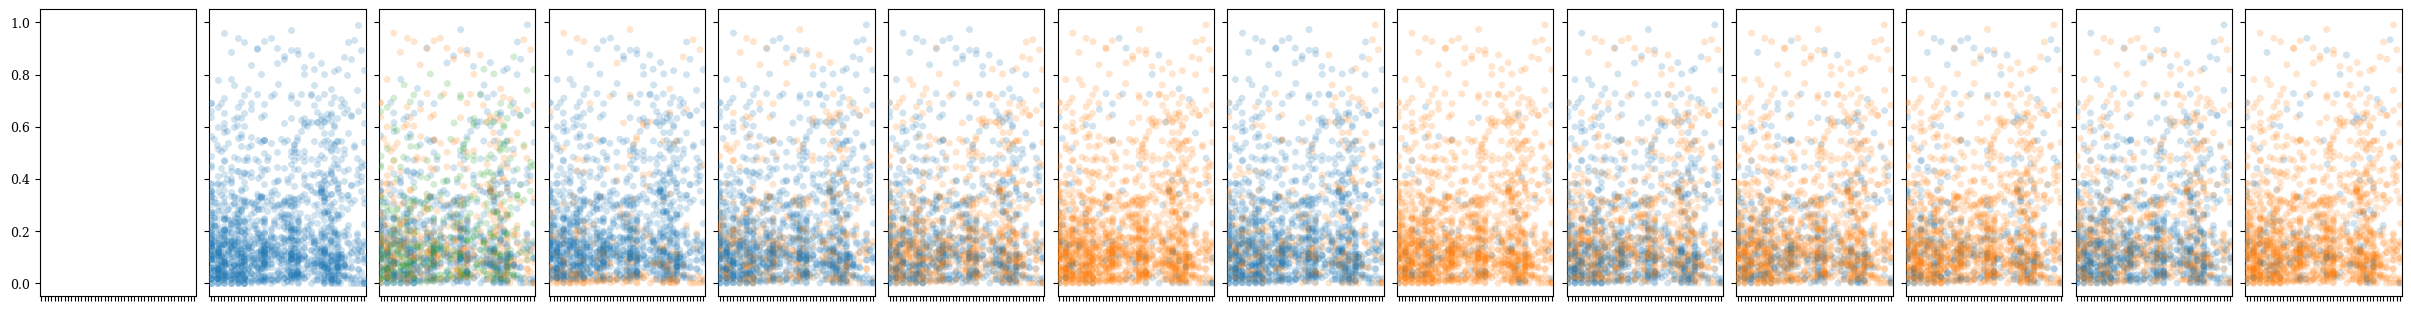

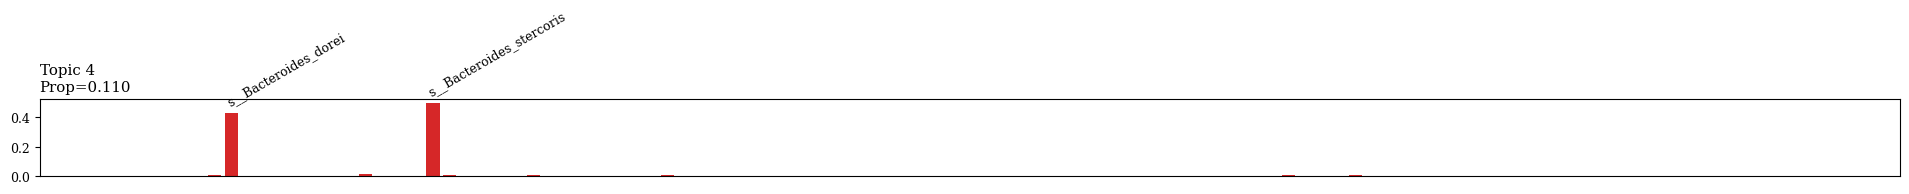

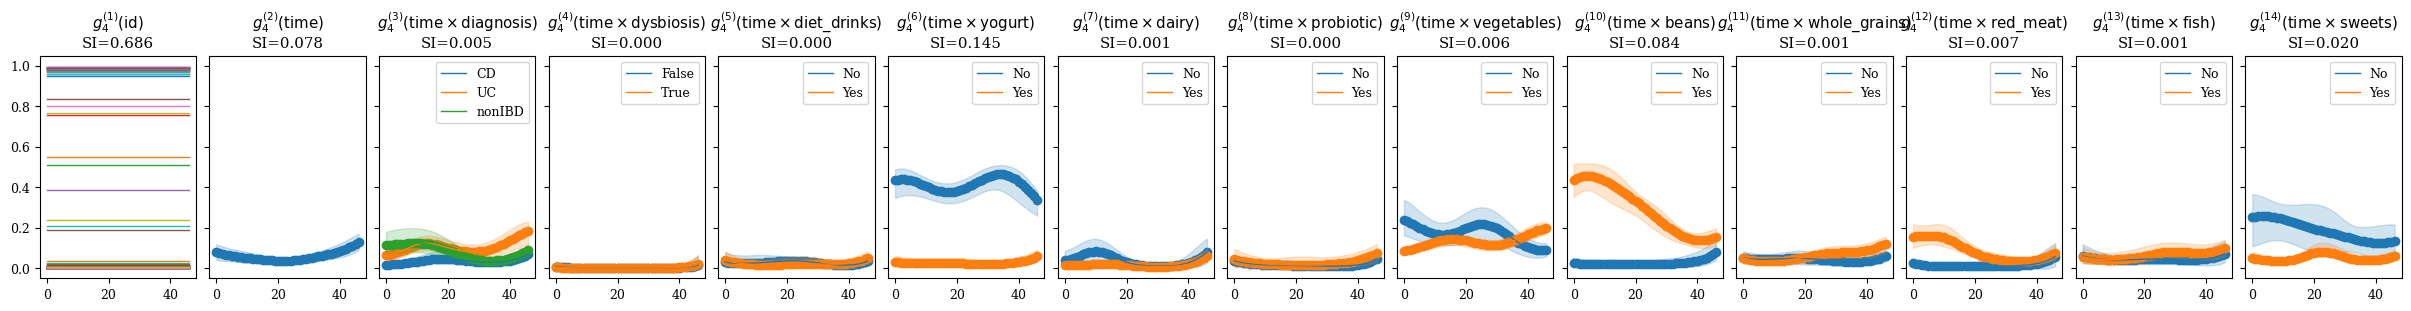

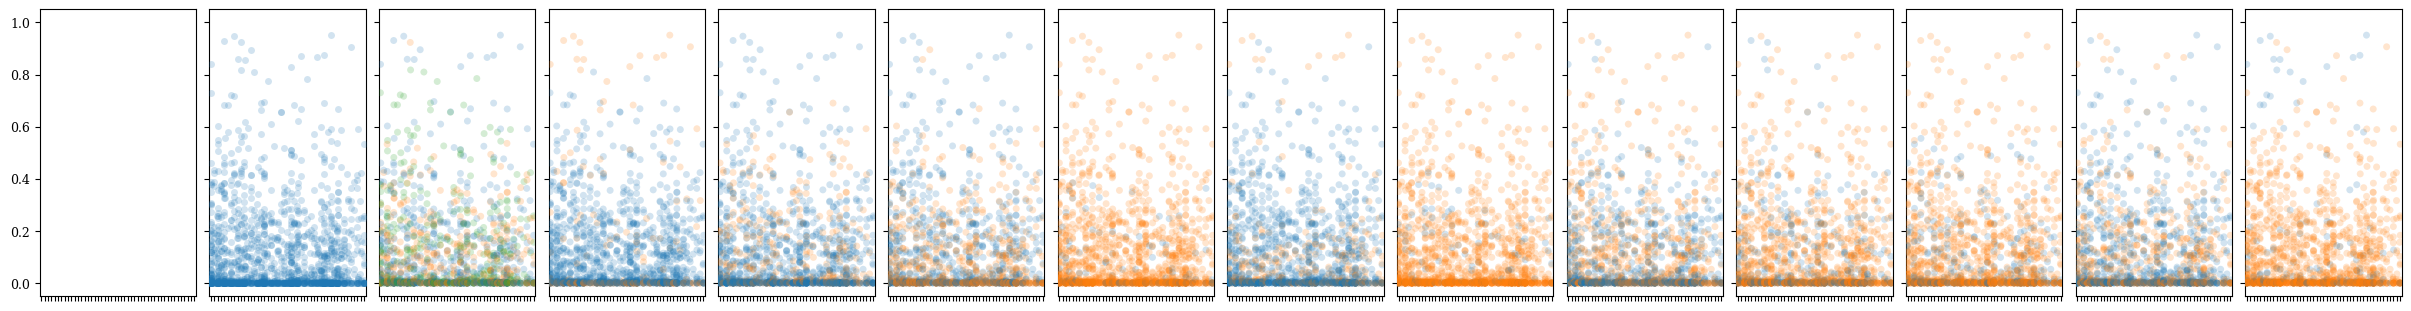

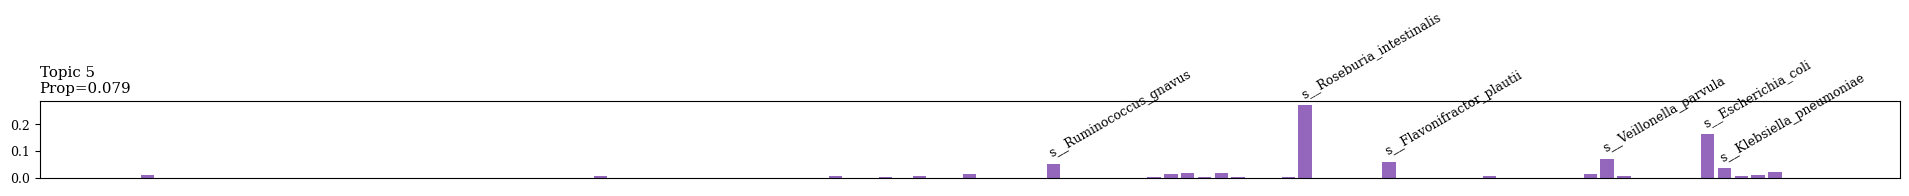

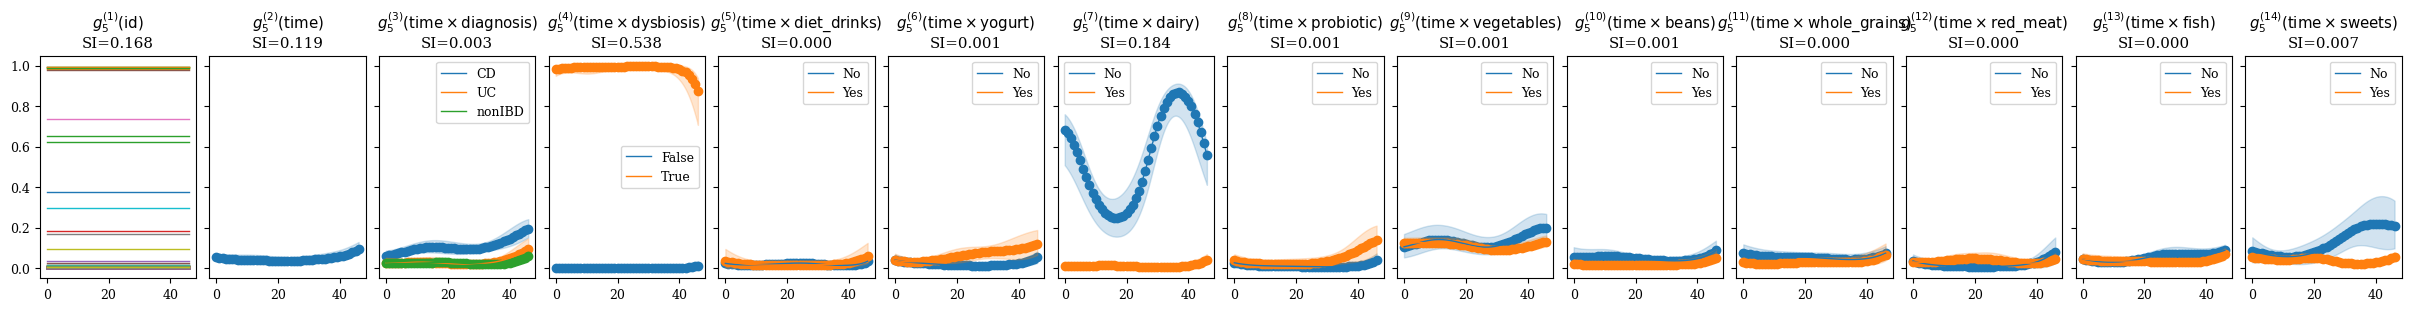

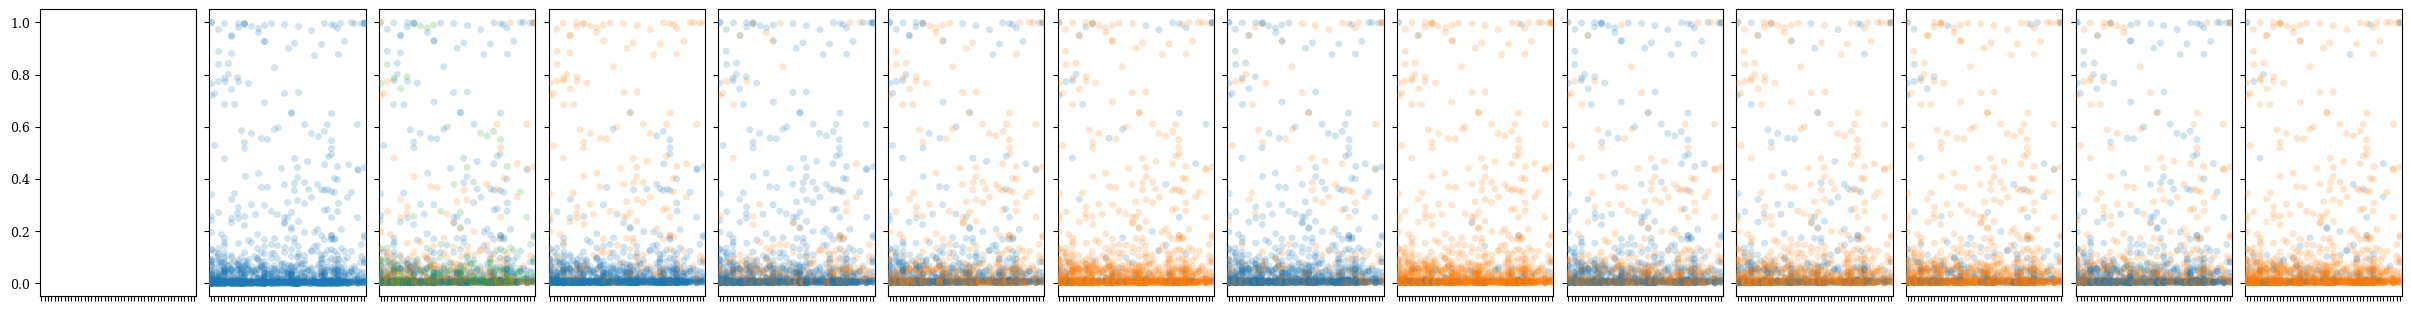

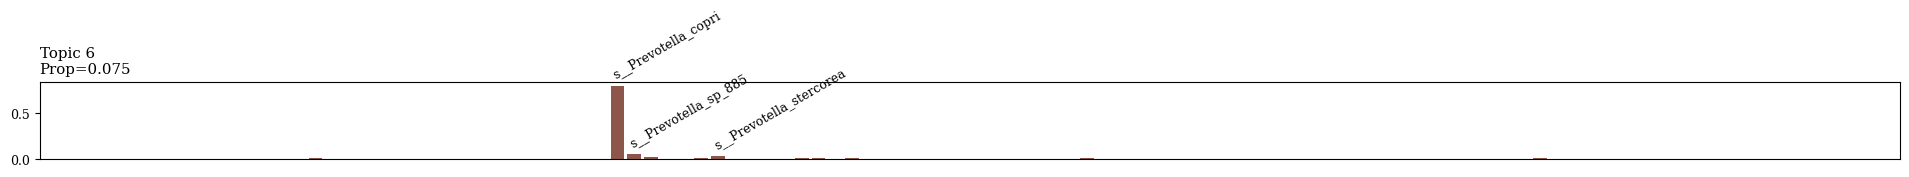

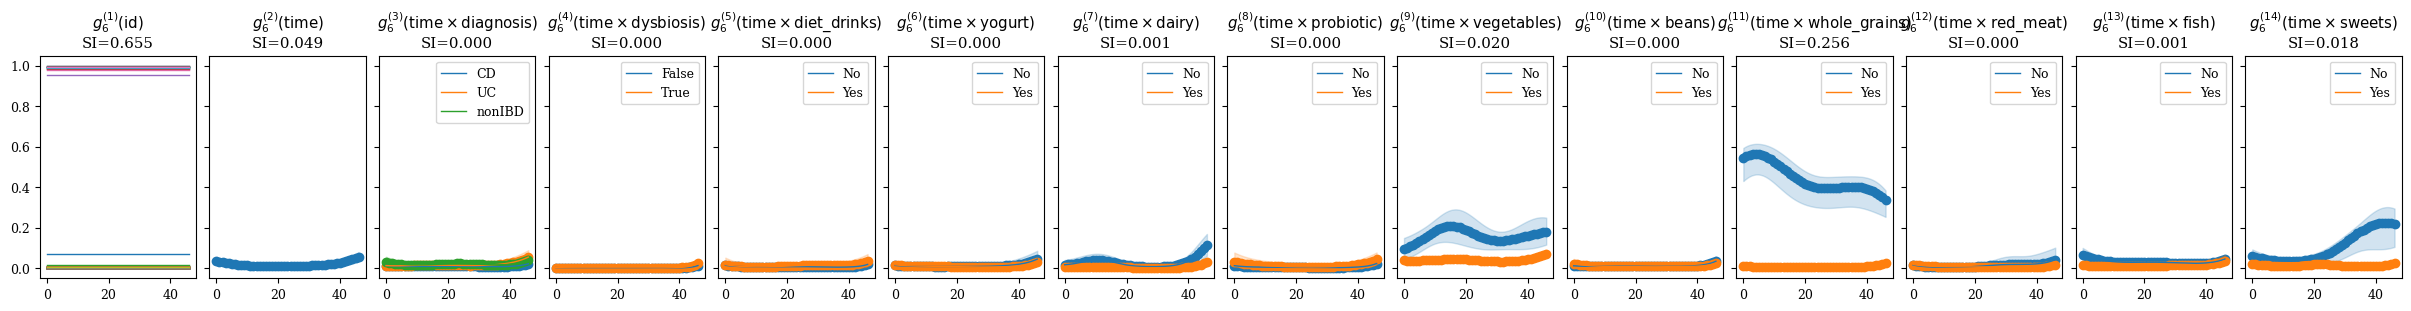

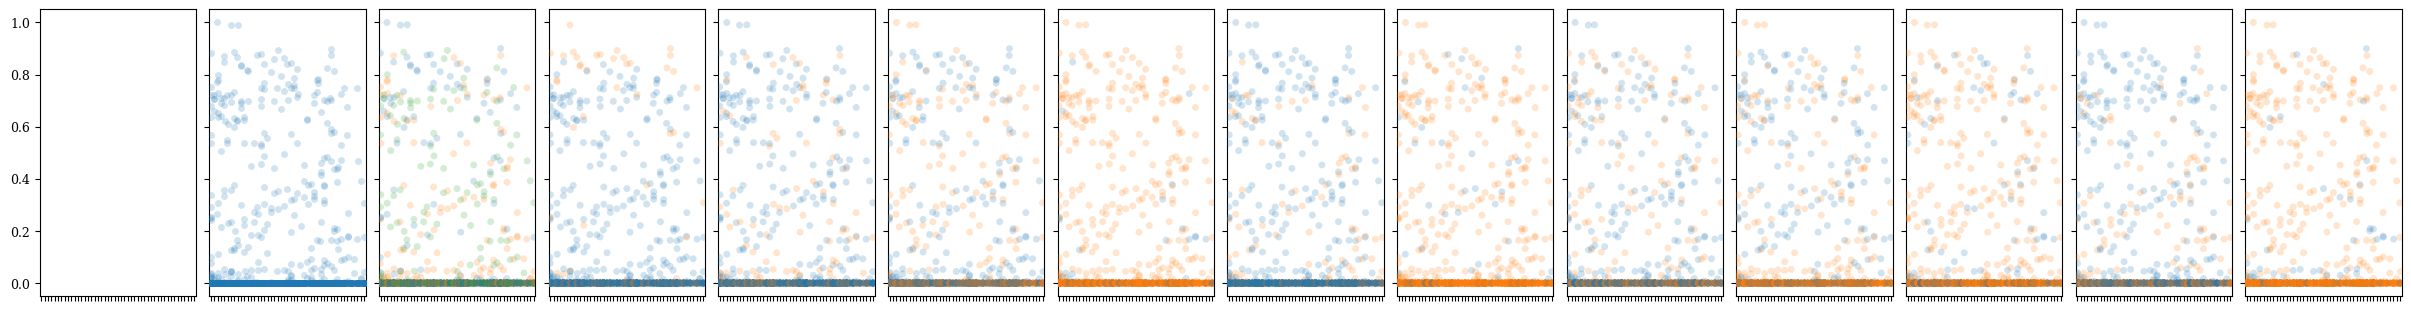

In [10]:
plt.rcParams.update({"font.size": 9})
colors = list(map(mpl.colors.to_hex, mpl.color_sequences["tab10"]))
plot_softmax = True
save_fmt = ""

l_sorted = np.argsort(np.mean(theta, axis=0))[::-1]
for cnt, l in enumerate(l_sorted):

    fig, ax = plt.subplots(figsize=(24, 1))
    bars = ax.bar(
        top_species, top_values[l], color=colors[cnt % len(colors)]
    )
    for bar, species_name in zip(bars, top_species):
        height = bar.get_height()
        if height > 0.03:
            ax.annotate(
                species_name,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="left",
                va="bottom",
                color="black",
                rotation=30,
                rotation_mode="anchor",
            )
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_title(f"Topic {cnt + 1}\nProp={np.mean(theta, axis=0)[l]:.3f}", loc="left")
    if save_fmt:
        plt.savefig(f"{cohort}-topic-{cnt + 1}.{save_fmt}", bbox_inches="tight")

    P = attrs.n_subjects
    T = attrs.n_steps
    x_num_dim = attrs.n_covariates
    ids = np.arange(P)
    timepoints = attrs.timepoints
    x_time = np.linspace(timepoints[0], timepoints[-1], num=10 * T)
    repeats = 100
    x_time_samples = np.tile(x_time, repeats)
    x_points = torch.zeros(T, x_num_dim)
    x_samples = torch.zeros(len(x_time), x_num_dim)

    fig, ax = plt.subplots(
        1,
        model.num_component,
        sharex=True,
        sharey=True,
        figsize=(24, 3),
        constrained_layout=True,
    )
    if plot_softmax:
        ax[0].set_ylim(-0.05, 1.05)

    if model.id_idx:
        for id_ in ids:
            x_points[:, 1] = id_
            z_id, _, _ = model.covariate_modules[0](
                x_points,
                stochastic_flag=False,
            )
            z_id = z_id.squeeze().detach().cpu().numpy()
            if plot_softmax:
                z_id = softmax(z_id, axis=-1)
            ax[0].plot(timepoints, z_id[:, l])
        title = (
            rf"$g_{{{cnt + 1}}}^{{({1})}}(\text{{id}})$"
            + f"\nSI={sobol_result.total_order[l, 1]:.3f}"
        )
        ax[0].set_title(title)

    if model.se_idx:
        i = 1 if model.id_idx else 0
        x_points[:, 0] = torch.tensor(
            dataset.scaler.transform(timepoints[:, np.newaxis])
        ).squeeze()
        z_time, _, _ = model.covariate_modules[i](x_points, stochastic_flag=False)
        z_time = z_time.squeeze().detach().cpu().numpy()
        if plot_softmax:
            z_time = softmax(z_time, axis=-1)
        ax[i].scatter(timepoints, z_time[:, l])
        x_samples[:, 0] = torch.tensor(
            dataset.scaler.transform(x_time[:, np.newaxis])
        ).squeeze()
        z_time, _, _ = model.covariate_modules[i](x_samples, stochastic_flag=False)
        z_time = z_time.squeeze().detach().cpu().numpy()
        if plot_softmax:
            z_time = softmax(z_time, axis=-1)
        ax[i].plot(x_time, z_time[:, l])
        z_time_samples = []
        for _ in range(repeats):
            z_time, _, _ = model.covariate_modules[i](
                x_samples.unsqueeze(1), stochastic_flag=True
            )
            z_time = z_time.squeeze().detach().cpu().numpy()
            if plot_softmax:
                z_time = softmax(z_time, axis=-1)
            z_time_samples.append(z_time)
        z_time_samples = np.concatenate(z_time_samples, axis=0)
        sns.lineplot(
            x=x_time_samples,
            y=z_time_samples[:, l],
            errorbar=("sd", 1),
            ax=ax[i],
            linestyle="",
            color=colors[0],
        )
        title = (
            rf"$g_{{{cnt + 1}}}^{{({i + 1})}}(\text{{time}})$"
            + f"\nSI={sobol_result.total_order[l, 0]:.3f}"
        )
        ax[i].set_title(title)

    for i in range(model.num_component):
        if model.covariate_modules[i].covar_type != "PROD":
            continue
        cat_covar = model.covariate_modules[i].cat_covar
        cat_name = attrs.x_cols[cat_covar]
        labels = attrs.df[cat_name].cat.categories
        for code in range(len(labels)):
            x_points[:, cat_covar] = code
            z_time_cat, _, _ = model.covariate_modules[i](
                x_points, stochastic_flag=False
            )
            z_time_cat = z_time_cat.squeeze().detach().cpu().numpy()
            if plot_softmax:
                z_time_cat = softmax(z_time_cat, axis=-1)
            ax[i].scatter(timepoints, z_time_cat[:, l], label=None, color=colors[code])
            x_samples[:, cat_covar] = code
            z_time_cat, _, _ = model.covariate_modules[i](
                x_samples, stochastic_flag=False
            )
            z_time_cat = z_time_cat.squeeze().detach().cpu().numpy()
            if plot_softmax:
                z_time_cat = softmax(z_time_cat, axis=-1)
            ax[i].plot(
                x_time, z_time_cat[:, l], label=labels[code], color=colors[code]
            )
            z_time_cat_samples = []
            for _ in range(repeats):
                z_time_cat, _, _ = model.covariate_modules[i](
                    x_samples.unsqueeze(1), stochastic_flag=True
                )
                z_time_cat = z_time_cat.squeeze().detach().cpu().numpy()
                if plot_softmax:
                    z_time_cat = softmax(z_time_cat, axis=-1)
                z_time_cat_samples.append(z_time_cat)
            z_time_cat_samples = np.concatenate(z_time_cat_samples, axis=0)
            sns.lineplot(
                x=x_time_samples,
                y=z_time_cat_samples[:, l],
                errorbar=("sd", 1),
                ax=ax[i],
                linestyle="",
                color=colors[code],
            )
        ax[i].legend()
        title = (
            rf"$g_{{{cnt + 1}}}^{{({i + 1})}}(\text{{time}}\times\text{{{cat_name}}})$"
            + f"\nSI={sobol_result.total_order[l, cat_covar]:.3f}"
        )
        ax[i].set_title(title)

    for i in range(model.num_component):
        if model.covariate_modules[i].covar_type != "CA":
            continue
        cat_covar = model.covariate_modules[i].index
        cat_name = attrs.x_cols[cat_covar]
        labels = attrs.df[cat_name].cat.categories
        for code in range(len(labels)):
            x_points[:, cat_covar] = code
            z_cat, _, _ = model.covariate_modules[i](
                x_points, stochastic_flag=False
            )
            z_cat = z_cat.squeeze().detach().cpu().numpy()
            if plot_softmax:
                z_cat = softmax(z_cat, axis=-1)
            ax[i].plot(
                timepoints, z_cat[:, l], label=labels[code], color=colors[code]
            )
        ax[i].legend()
        title = (
            rf"$g^{{({i + 1})}}(\text{{{cat_name}}})$"
            + f"\nSI={sobol_result.total_order[l, cat_covar]:.3f}"
        )
        ax[i].set_title(title)

    if save_fmt:
        plt.savefig(f"{cohort}-gp-{cnt + 1}.{save_fmt}")

    fig, ax = plt.subplots(
        1,
        model.num_component,
        sharex=True,
        sharey=True,
        figsize=(24, 3),
        constrained_layout=True,
    )
    if plot_softmax:
        ax[0].set_ylim(-0.05, 1.05)

    i = 1 if model.id_idx else 0
    np.random.seed(0)
    sns.stripplot(
        data=attrs.df,
        x="time",
        y=theta[:, l],
        alpha=0.2,
        ax=ax[i],
    )
    ax[i].set_xticklabels([])
    ax[i].set_xlabel("")

    for i in range(model.num_component):
        if model.covariate_modules[i].covar_type != "PROD":
            continue
        cat_covar = model.covariate_modules[i].cat_covar
        cat_name = attrs.x_cols[cat_covar]
        np.random.seed(0)
        sns.stripplot(
            data=attrs.df,
            x="time",
            y=theta[:, l],
            hue=cat_name,
            alpha=0.2,
            legend=False,
            ax=ax[i],
        )
        ax[i].set_xticklabels([])
        ax[i].set_xlabel("")

    for i in range(model.num_component):
        if model.covariate_modules[i].covar_type != "CA":
            continue
        cat_covar = model.covariate_modules[i].index
        cat_name = attrs.x_cols[cat_covar]
        np.random.seed(0)
        sns.stripplot(
            data=attrs.df,
            x="time",
            y=theta[:, l],
            hue=cat_name,
            alpha=0.2,
            legend=False,
            ax=ax[i],
        )
        ax[i].set_xticklabels([])
        ax[i].set_xlabel("")

    if save_fmt:
        plt.savefig(f"{cohort}-latent-{cnt + 1}.{save_fmt}", bbox_inches="tight")